# PATE MNIST Analysis
**TLDR**: train a DP (defferential privacy) model using this PATE method on the MNIST dataset.

Task: Assume we have a private unlabaled dataset and access to external models trained to similar datasets and with a common interface. We want to train our model on our dataset using the predictions of the others for labeling, while keeping the external models's data and our own within some privacy parameters.

Here we simulate the whole process, from the training of the external datasets to our own and measuring the epsilon-privacy using PATE.

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from syft.frameworks.torch.differential_privacy import pate

import helper

W0809 17:28:48.983058 140361009932096 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/home/vanntile/.local/lib/python3.6/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0809 17:28:48.995250 140361009932096 deprecation_wrapper.py:119] From /home/vanntile/.local/lib/python3.6/site-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



## 2. Define a feedforward neural network

In [2]:
# Network is a typical feedforward neural network
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [3]:
def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device) # training on CUDA, if possible

        images = images.resize_(images.size()[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy

In [4]:
def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=60):
    steps = 0
    running_loss = 0
    
    accuracies = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for e in range(epochs):
        print("Epoch: {}/{}.. ".format(e+1, epochs))
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device) # training on CUDA, if possible
        
            steps += 1
            
            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], 784)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                accuracies.append(accuracy/len(testloader))
                
                print("Training Loss: {:.4f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.4f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.4f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()
    
    return accuracies

## 3. Import MNIST data

In [5]:
# Split a list into n parts
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [6]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.RandomRotation(15), transforms.ToTensor()])

# Download the training data
dataset_train = datasets.MNIST(root='./MNIST_data', train=True, download=True, transform=transform)

# Simulating having multiple separated datasets
random_seed = 42
no_datasets = 6 # Chosen for easiness, MNIST has 60000 images
dataset_size = len(dataset_train)
indices = list(range(dataset_size))

np.random.seed(random_seed)
np.random.shuffle(indices)

indices = list(split(indices, no_datasets))

# Creating data samplers and loaders:
samplers = list()
for i in indices:
    sampler = SubsetRandomSampler(i)
    samplers.append(sampler)

train_dataloaders = list()
for s in samplers:
    loader = torch.utils.data.DataLoader(dataset_train, batch_size=32, sampler=s)
    train_dataloaders.append(loader)

# Download and load the test data
dataset_test = datasets.MNIST(root='./MNIST_data', train=False, download=True, transform=transform)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

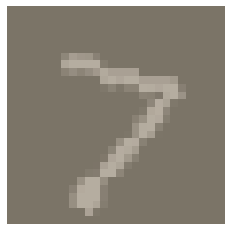

In [7]:
images, labels = next(iter(dataloader_test))
helper.imshow(images[0,:])

## 4. Train the models

=== Model #1/6 ===
Epoch: 1/1.. 
Training Loss: 1.9363..  Test Loss: 1.0918..  Test Accuracy: 0.6603
Training Loss: 1.0398..  Test Loss: 0.6290..  Test Accuracy: 0.7999
Training Loss: 0.7456..  Test Loss: 0.4959..  Test Accuracy: 0.8483
Training Loss: 0.6424..  Test Loss: 0.4478..  Test Accuracy: 0.8605
Training Loss: 0.6003..  Test Loss: 0.3816..  Test Accuracy: 0.8854
=== Model #2/6 ===
Epoch: 1/1.. 
Training Loss: 1.8987..  Test Loss: 1.0516..  Test Accuracy: 0.6536
Training Loss: 1.0359..  Test Loss: 0.6429..  Test Accuracy: 0.8056
Training Loss: 0.7404..  Test Loss: 0.4679..  Test Accuracy: 0.8561
Training Loss: 0.6503..  Test Loss: 0.4299..  Test Accuracy: 0.8704
Training Loss: 0.5703..  Test Loss: 0.3824..  Test Accuracy: 0.8828
=== Model #3/6 ===
Epoch: 1/1.. 
Training Loss: 1.8612..  Test Loss: 0.9238..  Test Accuracy: 0.6884
Training Loss: 1.0169..  Test Loss: 0.6275..  Test Accuracy: 0.7977
Training Loss: 0.7675..  Test Loss: 0.4879..  Test Accuracy: 0.8446
Training Loss: 0.

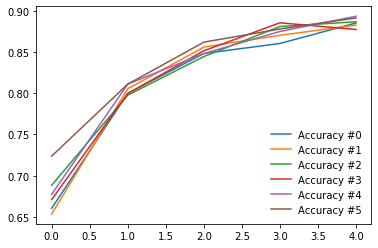

In [8]:
# Define a network model
criterion = nn.NLLLoss()

# Train a different model for each dataset
models = list()
for i in range(no_datasets):
    print("=== Model #{}/{} ===".format(i + 1, no_datasets))
    model = Network(784, 10, [512, 256, 128])
    optimizer = optim.Adam(model.parameters(), lr=0.001) # low learning rate to simulate real life
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    acc = train(model, train_dataloaders[i], dataloader_test, criterion, optimizer, epochs=1)
    plt.plot(acc, label=('Accuracy #' + str(i)))
    models.append(model)
plt.legend(frameon=False)

## 5. Using the models to create predictions

In [9]:
# Predicting the outputs
def predict():
    predictions = torch.torch.zeros((len(models), dataset_size // no_datasets), dtype=torch.long)

    for i, model in enumerate(models):
        prediction = torch.zeros(0, dtype=torch.long).to(device)
        
        for images, labels in dataloader_test:
            images, labels = images.to(device), labels.to(device) # training on CUDA, if possible

            images = images.resize_(images.size()[0], 784)
            output = model.forward(images)
            ps = torch.argmax(torch.exp(output), dim=1)
            prediction = torch.cat((prediction, ps))
            
        predictions[i] = prediction

    return predictions.numpy()

In [10]:
# Normalizing the predictions and getting the consensus
def normalising(predictions, epsilon):
    temp = [[] for i in range(len(predictions[0]))]

    for l in predictions:
        for i in range(len(l)):
            temp[i].append(l[i])

    consensus = list()
    
    for p in temp:

        label_counts = np.bincount(p, minlength=10)

        beta = 1 / epsilon

        for i in range(len(label_counts)):
            label_counts[i] += np.random.laplace(0, beta, 1)

        new_label = np.argmax(label_counts)

        consensus.append(new_label)

    consensus = np.asarray(consensus)
    return consensus

In [11]:
eps = 0.5

predictions = predict()
consensus = normalising(predictions, eps)

## 6. PATE Analysis

In [12]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=np.asarray(predictions), indices=consensus, noise_eps=eps, delta=1e-5, moments=4)

print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 10002.878231366243
Data Dependent Epsilon: 10002.878231366243


## 7. Training our model

Hypothesis - we have a private dataset (in this experiment dataset_test), unlabeled, and we use the consensus prediction from the sister-models, using the privacy determined by the data dependent epsilon above to train our model. Consequently, we can both train our model privately, never exchanging data between us and an external party (with the specific privacy). Obviously the accuracy is lower than when we would train without adding noise to our data, just taking the `argmax` of the predictions.

### Adding the predicted consensus label to our private dataset

In [13]:
# we will use dataloader_test to simulate our private dataset even though
# in real life it would be a completey different one
# private_loader(dataloader_test, consensus)

def private_loader(trainloader, new_labels):
    for i, (data, _) in enumerate(iter(trainloader)):
        new_label = torch.from_numpy(new_labels[i*len(data):(i+1)*len(data)])
        yield data, new_label

### Training and evaluating our model

Epoch: 1/1.. 
Training Loss: 2.1997..  Test Loss: 1.6949..  Test Accuracy: 0.4269
Training Loss: 1.9977..  Test Loss: 1.4514..  Test Accuracy: 0.6677
Training Loss: 1.8806..  Test Loss: 1.2718..  Test Accuracy: 0.7193
Training Loss: 1.7804..  Test Loss: 1.0204..  Test Accuracy: 0.7909
Training Loss: 1.7630..  Test Loss: 1.1503..  Test Accuracy: 0.8118


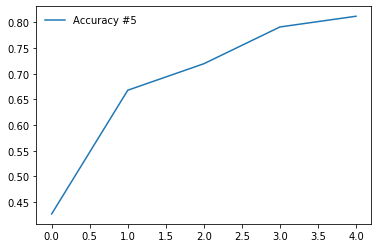

In [14]:
# Define a network model
model = Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # low learning rate to simulate real life

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

acc = train(model, private_loader(dataloader_test, consensus), dataloader_test, criterion, optimizer, epochs=1)

plt.plot(acc, label=('Accuracy'))
plt.legend(frameon=False)